# Classifying Exoplanets



In [ ]:

%tensorflow_version 2.x
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df_train = pd.read_csv('exoTrain.csv')
df_train.LABEL = df_train.LABEL -1
df_test = pd.read_csv('exoTest.csv')
df_test.LABEL = df_test.LABEL - 1

def plot_graphs(history, best):

  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def analyze_results(model, train_X, train_y, test_X, test_y):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    train_y : array-like of shape (n_samples,)
    Target values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    test_y : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    if type(model) == keras.engine.sequential.Sequential:
      train_predictions = model.predict(train_X)
      train_predictions = (train_predictions > 0.5)
      cm = confusion_matrix(train_y, train_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      plt.close()
      ConfusionMatrixDisplay.from_estimator(model,train_X,train_y)
      plt.show()

    print("Testing:")
    if type(model) == keras.engine.sequential.Sequential:
      test_predictions = model.predict(test_X)
      test_predictions = (test_predictions > 0.5)
      cm = confusion_matrix(test_y, test_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      ConfusionMatrixDisplay.from_estimator(model,test_X,test_y)

def reset(train,test):
    train_X = train.drop('LABEL', axis=1)
    train_y = train['LABEL'].values
    test_X = test.drop('LABEL', axis=1)
    test_y = test['LABEL'].values
    return train_X,train_y,test_X,test_y

train_X,train_y,test_X,test_y = reset(df_train, df_test)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
exoTrain.csv        100%[===================>] 250.08M   189MB/s    in 1.3s    
exoTest.csv         100%[===================>]  27.57M  17.3MB/s    in 1.6s    


In [ ]:
#Data preprocessing
# Helper functions that we can run for the three augmentation functions that will be used, but not explroed in depth

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    train_X = np.abs(np.fft.fft(df1, axis=1))
    test_X = np.abs(np.fft.fft(df2, axis=1))
    return train_X,test_X

def norm(df1,df2):
    train_X = normalize(df1)
    test_X = normalize(df2)
    return train_X,test_X

def robust(df1,df2):
    scaler = RobustScaler()
    train_X = scaler.fit_transform(df1)
    test_X = scaler.transform(df2)
    return train_X,test_X

fourier_train_X, fourier_test_X = fourier(train_X, test_X)
savgol_train_X, savgol_test_X = savgol(fourier_train_X, fourier_test_X)
norm_train_X, norm_test_X = norm(savgol_train_X,savgol_test_X)
robust_train_X, robust_test_X = robust(norm_train_X, norm_test_X)
smote_train_X,smote_train_y = smote(robust_train_X, train_y)

# Here we're adding the generated, augmented data onto the testing data
aug_train_X, new_X_test_data, aug_train_y, new_y_test_data = train_test_split(smote_train_X, smote_train_y, test_size=0.3)
aug_test_X = np.concatenate((robust_test_X, new_X_test_data), axis=0)
aug_test_y = np.concatenate((test_y, new_y_test_data), axis=0)


## Multi-Layer Perception Neural Network





In [ ]:
# Create an MLP model (will train later)

model = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(10))

In [ ]:
#YOUR CODE HERE
# For example, if you were using the Model class
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
model.fit(aug_train_X, aug_train_y)

train_predictions = model.predict(aug_train_X)
test_predictions = model.predict(aug_test_X)
print(accuracy_score(aug_train_y, train_predictions))
print(accuracy_score(aug_test_y, test_predictions))


1.0
0.9969444444444444


## Neural Networks (Tensorflow and Keras)

In [ ]:

model = Sequential()


model.add(Dense(10,input_shape = (3197,), activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now to check the details of your model, run the code block below.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │          31,980 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,991 (124.96 KB)

 Trainable params: 31,991 (124.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

batch_size = 64
epochs = 20
validation_data = (aug_test_X, aug_test_y)
verbose = 1
shuffle = True
history = model.fit(aug_train_X, aug_train_y, batch_size=batch_size, epochs=epochs, verbose=verbose,validation_data=validation_data, shuffle=shuffle)

####################

Epoch 1/20
111/111 [==============================] - 6s 7ms/step - loss: 0.1478 - accuracy: 0.9474 - val_loss: 0.0853 - val_accuracy: 0.9675
Epoch 2/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0475 - accuracy: 0.9853 - val_loss: 0.0712 - val_accuracy: 0.9689
Epoch 3/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.0419 - val_accuracy: 0.9853
Epoch 4/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0283 - accuracy: 0.9900 - val_loss: 0.0253 - val_accuracy: 0.9942
Epoch 5/20
111/111 [==============================] - 0s 4ms/step - loss: 0.0176 - accuracy: 0.9936 - val_loss: 0.0274 - val_accuracy: 0.9911
Epoch 6/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.0222 - val_accuracy: 0.9931
Epoch 7/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0198 - val_accuracy: 0.9942
Epoch 

Now we will see how to view the performance of the model as it trained over time!

In addition, we still want to be able to plot the confusion matrix of the model to check for performance and potential class biases. Enter code to analyze the model in the empty portion of the codeblock below.

57/57 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9947


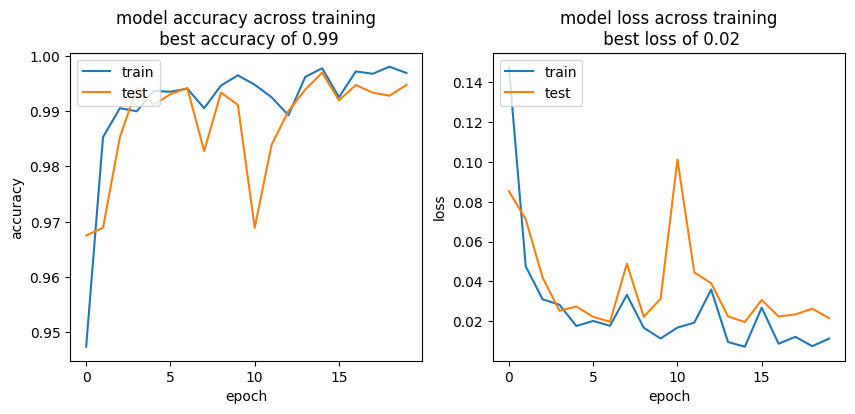

-------------------------------------------
Model Results

Training:
221/221 [==============================] - 0s 2ms/step


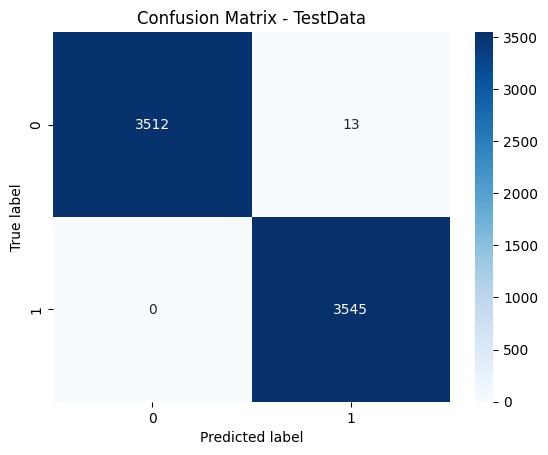

Testing:
113/113 [==============================] - 0s 2ms/step


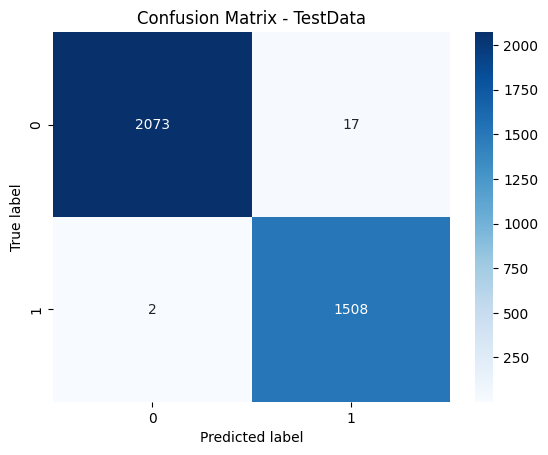

In [ ]:
performance = model.evaluate(aug_test_X, aug_test_y, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)


##############

## Covolutional Neural Network (CNN)

This is an architecture that can make decisions based on patterns no matter where they occur in the sample.


First, we'll have to "reshape" our augmented data into a shape that can be fed into a 1-dimensional CNN.


In [ ]:
cnn_aug_train_X = np.expand_dims(aug_train_X, axis=2)
cnn_aug_train_y = aug_train_y

cnn_aug_test_X = np.expand_dims(aug_test_X, axis=2)
cnn_aug_test_y = aug_test_y



cnn_train_X = np.expand_dims(train_X, axis=2)
cnn_train_y = train_y

cnn_test_X = np.expand_dims(test_X, axis=2)
cnn_test_y = test_y



What are the new shapes of the data? The new data is stored in variables: `cnn_aug_train_X`, `cnn_aug_test_X`, `cnn_aug_train_y`, `cnn_aug_test_y`.

In [ ]:
# YOUR CODE HERE
print(cnn_aug_train_X.shape)
print(cnn_aug_test_X.shape)
print(cnn_aug_train_y.shape)
print(cnn_aug_test_y.shape)

(7070, 3197, 1)
(3600, 3197, 1)
(7070,)
(3600,)


In [ ]:
# First, we initialize our model
model = Sequential()
input_shape = [3197, 1]

cnn_layer_1 = Conv1D(8, 5, activation='relu', input_shape=input_shape, padding='same')
cnn_layer_2 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_3 = Conv1D(16, 3, activation='relu', padding='same')
cnn_layer_4 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_5 = Flatten()
cnn_layer_6 = Dense(1, activation='sigmoid')


model.add(cnn_layer_1)
model.add(cnn_layer_2)
model.add(cnn_layer_3)
model.add(cnn_layer_4)
model.add(cnn_layer_5)
model.add(cnn_layer_6)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Train the Model

#######TODO#########

batch_size = 64
epochs = 20
validation_data = (cnn_aug_test_X, cnn_aug_test_y)
verbose = 1
shuffle = True

history = model.fit(cnn_aug_train_X, cnn_aug_train_y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                            validation_data=validation_data, shuffle=shuffle)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 0.9975 - val_loss: 0.0190
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9967 - val_loss: 0.0218
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9978 - loss: 0.0050 - val_accuracy: 0.9961 - val_loss: 0.0231
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9975 - val_loss: 0.0193
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9964 - val_loss: 0.0228
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9969 - val_loss: 0.0221
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9975 - val_loss: 0.0152
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9968 - loss: 0.0075 - val_accu

In [19]:
model = Sequential()
input_shape = [3197, 1]

cnn_layer_1 = Conv1D(8, 5, activation='relu', input_shape=input_shape, padding='same')
cnn_layer_2 = MaxPooling1D(pool_size=6, strides=1, padding='same')
cnn_layer_3 = Conv1D(16, 3, activation='relu', padding='same')
cnn_layer_4 = MaxPooling1D(pool_size=6, strides=2, padding='same')
cnn_layer_5 = Dropout(rate = 0.5)
cnn_layer_6 = Flatten()
cnn_layer_7 = Dense(1, activation='sigmoid')

# then we add a "Dense" (i.e. fully connected) layer
model.add(cnn_layer_1) # for the first layer we specify the input dimensions
model.add(cnn_layer_2)
model.add(cnn_layer_3)
model.add(cnn_layer_4)
model.add(cnn_layer_5)
model.add(cnn_layer_6)
model.add(cnn_layer_7)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 64
epochs = 20
validation_data = (cnn_aug_test_X, cnn_aug_test_y)
verbose = 1
shuffle = True

history = model.fit(cnn_aug_train_X, cnn_aug_train_y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                            validation_data=validation_data, shuffle=shuffle)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8699 - loss: 0.2949 - val_accuracy: 0.9892 - val_loss: 0.0469
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9783 - loss: 0.0664 - val_accuracy: 0.9839 - val_loss: 0.0414
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9910 - loss: 0.0320 - val_accuracy: 0.9958 - val_loss: 0.0186
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9964 - loss: 0.0160 - val_accuracy: 0.9981 - val_loss: 0.0223
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9960 - loss: 0.0139 - val_accuracy: 0.9978 - val_loss: 0.0116
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9979 - loss: 0.0097 - val_accuracy: 0.9964 - val_loss: 0.0134
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9981 - loss: 0.0093 - val_accuracy: 0.9989 - val_loss: 0.0102
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9978 - loss: 0.0090 - val_acc